In [1]:
import importlib
from pybit.unified_trading import HTTP
import os
from utils import utils
importlib.reload(utils)
from datetime import datetime
import pandas as pd 

class BybitWrapper():

    def __init__(self, demo=False, api_key=None, api_secret=None):
        print(f'Wrapper Activated. Demo Mode == {demo}')
        self.demo = demo
        
        if self.demo:   
            self.api_key = api_key or os.getenv("BYBIT_API_KEY_TEST")
            self.api_secret = api_secret or os.getenv("BYBIT_API_SECRET_TEST")
            self.session = HTTP(api_key=self.api_key, api_secret=self.api_secret, demo=demo, log_requests=True)
        else:
            self.api_key = api_key or os.getenv("BYBIT_API_KEY")
            self.api_secret = api_secret or os.getenv("BYBIT_API_SECRET")
            self.session = HTTP(api_key=self.api_key, api_secret=self.api_secret, demo=demo, log_requests=True)
        

    ###########################################################################
    ##########################  Account Data   ################################
    ########################################################################### 

    def transaction_log(self, account_type='UNIFIED', market=None, coin=None, limit=50):
        all_transactions = pd.DataFrame()  # Initialize an empty DataFrame
        cursor = None
        
        while True:
            # Make the API call with the current cursor
            response = self.session.get_transaction_log(
                accountType=account_type,
                category=market,
                baseCoin=coin,
                limit=limit,
                cursor=cursor
            )
            
            # Parse the current page of transactions and concatenate to the main DataFrame
            page_transactions = utils.parse_transaction_log(response)
            all_transactions = pd.concat([all_transactions, page_transactions], ignore_index=True)
            
            # Check for the next page cursor
            cursor = response.get('result', {}).get('nextPageCursor')
            if not cursor:
                break  # No more pages, exit loop

        # Return the combined transactions as a DataFrame
        return all_transactions


    def wallet_balance(self, account_type: str = 'UNIFIED', coin: str = None):
        
        response = self.session.get_wallet_balance(accountType=account_type, coin=coin)
        
        return utils.parse_wallet_balance(response)
    
    def get_coin_balance(self, account_type: str = 'UNIFIED', coin: str = None, member_id: str = None, with_bonus: int = 0):
        
        if self.demo:
            raise RuntimeError("This operation is not allowed in demo mode.")
        else:
            response = self.session.get_coins_balance(
                accountType=account_type,
                coin=coin,
                memberId=member_id,
                withBonus=with_bonus
            )
            return utils.parse_coin_balance(response=response)
    
    def get_api_details(self):
        if self.demo:
            raise RuntimeError("This operation is not allowed in demo mode.")
        else:
            response=self.session.get_api_key_information()
            return response
        
    ###########################################################################
    ##########################  Market Data   #################################
    ###########################################################################    
    

    # Market Data Endpoints (Common for Spot and Perpetual)
    def get_orderbook(self, ticker: str, category: str, limit: int = 100):
        response=self.session.get_orderbook(category=category, symbol=ticker, limit=limit)
        return utils.parse_orderbook(response=response)
    
    def get_candles(self, market, ticker, interval: str = "60", limit: int = 10):
        response=self.session.get_kline(category=market, symbol=ticker, interval=interval, limit=limit)
        return utils.parse_klines(response)


    ###########################################################################
    ##########################  Spot Order Management   #######################
    ###########################################################################

    # Might want to implement batch orders and payloads! 

    def build_spot_market_order_payload(self,
                                ticker: str, 
                                side: str, 
                                qty: float, 
                                execution_type: str = 'IOC', 
                                annotations: str = None) -> dict:
        """
        Builds the payload for a market order on the spot market.

        :param ticker: The trading pair symbol (e.g., 'BTCUSDT').
        :param side: The side of the order ('Buy' or 'Sell').
        :param qty: The quantity of the asset to buy or sell.
        :param execution_type: The order execution type ('GTC', 'IOC', etc.). Defaults to 'GTC'.
        :param annotations: Optional annotations for the order.
        :return: A dictionary payload for the order.
        """

        # Validate side parameter
        if side not in ['Buy', 'Sell']:
            raise ValueError("Invalid side, must be 'Buy' or 'Sell'.")

        # Validate execution_type parameter
        valid_execution_types = ['GTC', 'IOC', 'FOK']
        if execution_type not in valid_execution_types:
            raise ValueError(f"Invalid execution_type, must be one of {valid_execution_types}.")

        # Automate annotations if not provided
        if annotations is None:
            current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
            annotations = f"{side}_{(str(qty).replace('.', '-'))}_{ticker}_{current_time}"

        payload = {
            "category": "spot",
            "symbol": ticker,
            "side": side,
            "orderType": "Market",
            "qty": qty,
            "timeInForce": execution_type,
            "orderLinkId": annotations,
            "isLeverage": 0,
            "orderFilter": "Order"
        }

        return payload

    # Spot Market Endpoints
    def place_spot_market_order(self, payload: dict):
        """
        Places a market order on the spot market using a pre-built payload.

        :param payload: A dictionary containing the order details.
        :return: The API response from placing the order.
        """
        try:
            self.session.place_order(**payload)
            
        except Exception as e:
            print(f"Error placing order: {e}")
            return None

        return self.spot_order_history(ticker=payload.get('symbol'),limit=1)
    
    def cancel_spot_order(self, symbol: str, order_id: str):
        pass

    def spot_order_history(self, market: str = 'spot', ticker = None, limit: int = 100):
        
        
        response = self.session.get_order_history(category=market, 
                                                  symbol=ticker,
                                                  limit=limit
                                                  )
        
        
        return utils.parse_order_history(response)
    

    ###########################################################################
    ####################  Derivatives Position Management  ####################
    ########################################################################### 

    def leverage(self, market='linear', ticker: str = None, buy_leverage: str = None, sell_leverage: str = None): 
        
        response = self.session.set_leverage(category=market,
                                             symbol=ticker,
                                             buyLeverage=buy_leverage,
                                             sellLeverage=sell_leverage)
        
        return response 


    def build_perp_market_order_payload(self,
                                ticker: str, 
                                side: str, 
                                qty: float, 
                                execution_type: str = 'IOC', 
                                annotations: str = None) -> dict:
        """
        Builds the payload for a market order on the spot market.

        :param ticker: The trading pair symbol (e.g., 'BTCUSDT').
        :param side: The side of the order ('Buy' or 'Sell').
        :param qty: The quantity of the asset to buy or sell.
        :param execution_type: The order execution type ('GTC', 'IOC', etc.). Defaults to 'GTC'.
        :param annotations: Optional annotations for the order.
        :return: A dictionary payload for the order.
        """

        # Validate side parameter
        if side not in ['Buy', 'Sell']:
            raise ValueError("Invalid side, must be 'Buy' or 'Sell'.")

        # Validate execution_type parameter
        valid_execution_types = ['GTC', 'IOC', 'FOK']
        if execution_type not in valid_execution_types:
            raise ValueError(f"Invalid execution_type, must be one of {valid_execution_types}.")

        # Automate annotations if not provided
        if annotations is None:
            current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
            annotations = f"{side}_{(str(qty).replace('.', '-'))}_{ticker}_{current_time}"

        payload = {
            "category": "linear",
            "symbol": ticker,
            "side": side,
            "orderType": "Market",
            "qty": qty,
            "timeInForce": execution_type,
            "orderLinkId": annotations,
            "isLeverage": 0,
            "orderFilter": "Order"
        }

        return payload

    # Spot Market Endpoints
    def place_perp_market_order(self, payload: dict):
        """
        Places a market order on the spot market using a pre-built payload.

        :param payload: A dictionary containing the order details.
        :return: The API response from placing the order.
        """
        try:
            self.session.place_order(**payload)
            
        except Exception as e:
            print(f"Error placing order: {e}")
            return None

        return self.perp_order_history(ticker=payload.get('symbol'),limit=1)
    
    def perp_order_history(self, market: str = 'linear', ticker = None, limit: int = 100):
        
        
        response = self.session.get_order_history(category=market, 
                                                  symbol=ticker,
                                                  limit=limit
                                                  )
        
        
        return utils.parse_order_history(response)
    
    def cancel_all_ordera(self, market=None):
        response = self.session.cancel_all_orders(category=market)

        return response

    def positions(self, market: str = 'linear', ticker: str = None, settleCoin: str = 'USDT', limit: int = 20, cursor: str = None):
        
        response = self.session.get_positions(
            category=market,
            symbol=ticker,
            settleCoin=settleCoin,
            limit=limit,
            cursor=cursor
        )

        return utils.parse_positions(response)
    

    

In [2]:
wrapper=BybitWrapper(demo=False)
test_wrapper=BybitWrapper(demo=True)

Wrapper Activated. Demo Mode == False
Wrapper Activated. Demo Mode == True


### Account Data

In [ ]:
#wrapper.get_coin_balance() # not available in demo mode 

In [3]:
test_wrapper.transaction_log()

InvalidRequestError: API key is invalid. (ErrCode: 10003) (ErrTime: 18:17:33).
Request → GET https://api-demo.bybit.com/v5/account/transaction-log: accountType=UNIFIED&limit=50.

In [ ]:
test_wrapper.wallet_balance()

In [ ]:
test_wrapper.wallet_balance(account_type='UNIFIED')

### Market Data

In [ ]:
test_wrapper.get_candles(ticker='BTCUSDT', market='spot')

### Managing SPOT Orders

In [ ]:
# Build the payload
payload = test_wrapper.build_spot_market_order_payload(
    ticker='BTCUSDT', 
    side='Buy', # when side is 'BUY', qty is quoteCoin, when side is 'Sell', qty is baseCoin
    qty=1000,
)
payload


In [ ]:
# Place the order using the payload
test_wrapper.place_spot_market_order(payload)


In [ ]:
test_wrapper.spot_order_history()

### Managing PERP Orders

In [ ]:
test_wrapper.perp_order_history()

In [ ]:
test_wrapper.leverage(ticker='BTCUSDT', buy_leverage='1', sell_leverage='1')

In [ ]:
payload=test_wrapper.build_perp_market_order_payload(ticker='BTCUSDT',
                                             side= 'Buy',
                                             qty=1,
                                             execution_type='IOC',
                                             )
payload

In [ ]:
test_wrapper.place_perp_market_order(payload) # understand output 

In [ ]:
test_wrapper.positions()

In [ ]:
test_wrapper.transaction_log().iloc[:,1:15]

In [ ]:
test_wrapper.positions()

In [ ]:
from tradingStrategies import BuyNHold, AlphaTraderLongBiased, AFT01


apt = AFT01(1000, '2022-01-01', 'now')
apt1 = AlphaTraderLongBiased(1000, '2022-01-01', 'now')

In [7]:
bnh = BuyNHold(1000, '2022-01-01', 'now')

INFO:root:Successfully fetched data for endpoint: market/price_usd_close
INFO:root:Successfully fetched data for endpoint: indicators/ssr_oscillator
INFO:root:Successfully fetched data for endpoint: market/spot_cvd_sum
INFO:root:Successfully fetched data for endpoint: supply/profit_relative
INFO:root:Successfully fetched data for endpoint: mining/hash_rate_mean
INFO:root:Successfully merged data from all endpoints.
INFO:root:Fetched 1000 rows, total fetched: 1000
INFO:root:Fetched 1000 rows, total fetched: 2000
INFO:root:Fetched 1000 rows, total fetched: 3000
INFO:root:Fetched 1000 rows, total fetched: 4000
INFO:root:Fetched 1000 rows, total fetched: 5000
INFO:root:Fetched 1000 rows, total fetched: 6000
INFO:root:Fetched 1000 rows, total fetched: 7000
INFO:root:Fetched 1000 rows, total fetched: 8000
INFO:root:Fetched 1000 rows, total fetched: 9000
INFO:root:Fetched 1000 rows, total fetched: 10000
INFO:root:Fetched 1000 rows, total fetched: 11000
INFO:root:Fetched 1000 rows, total fetch

Wrapper Activated. Demo Mode == True


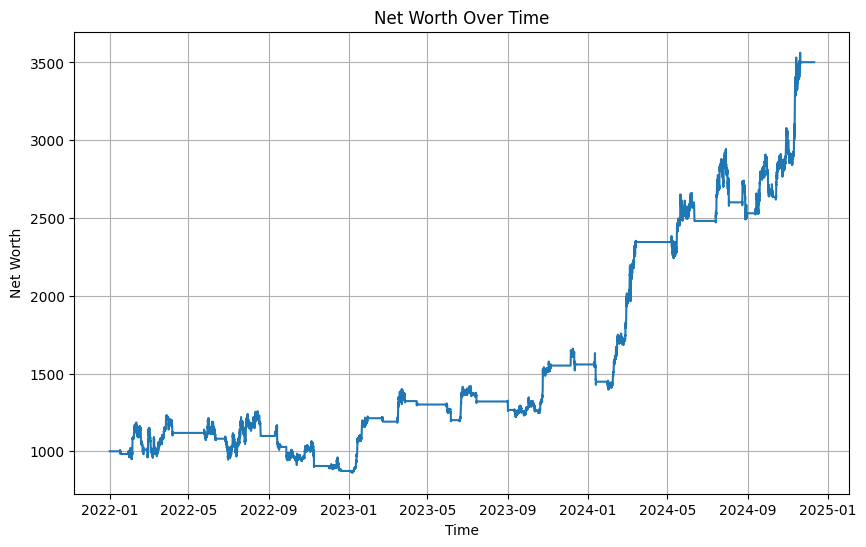

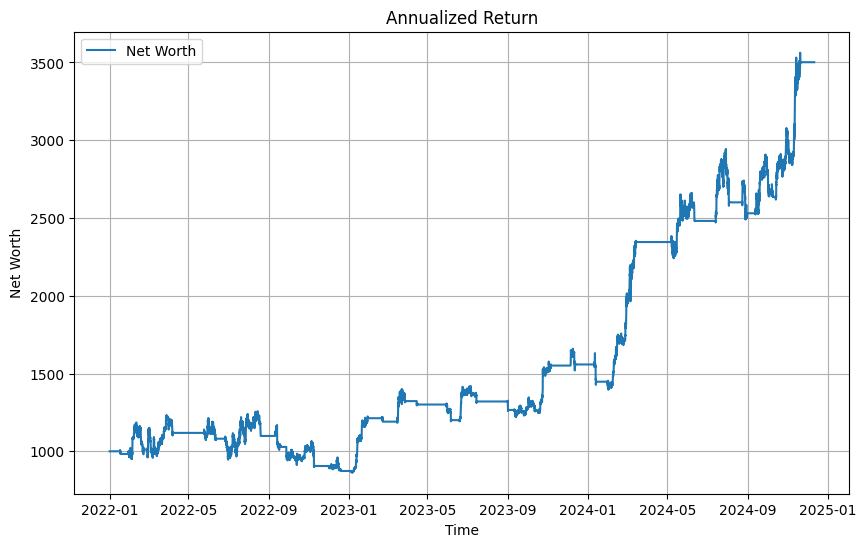

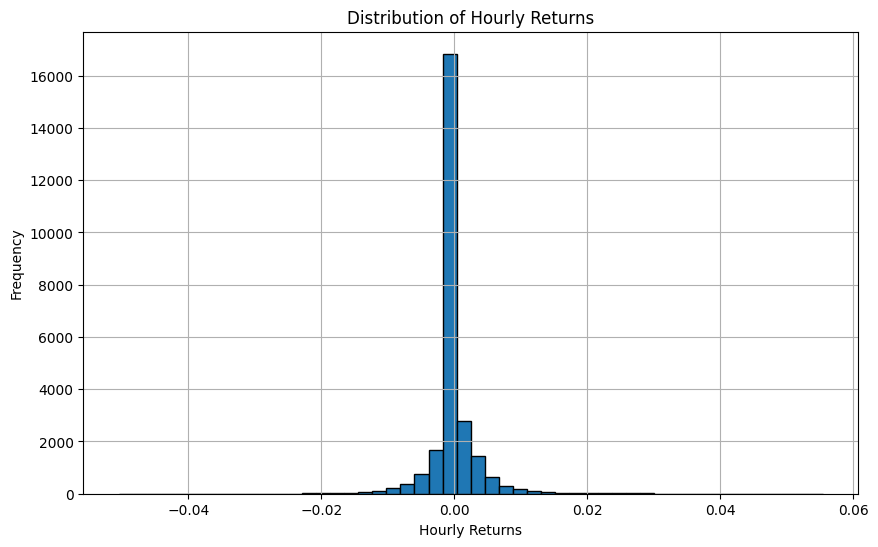

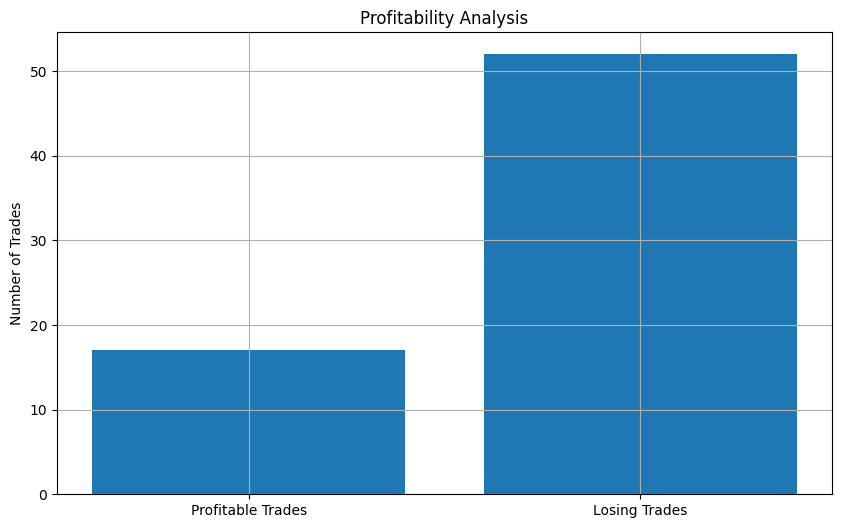

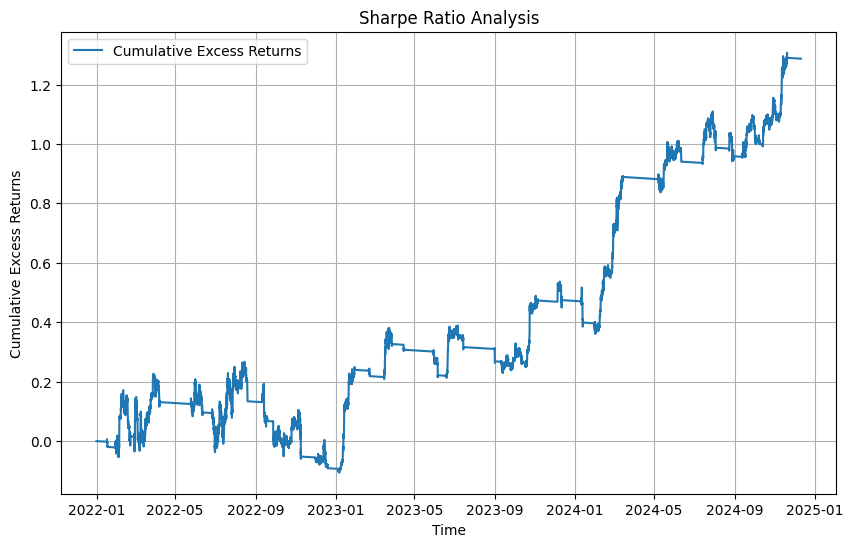

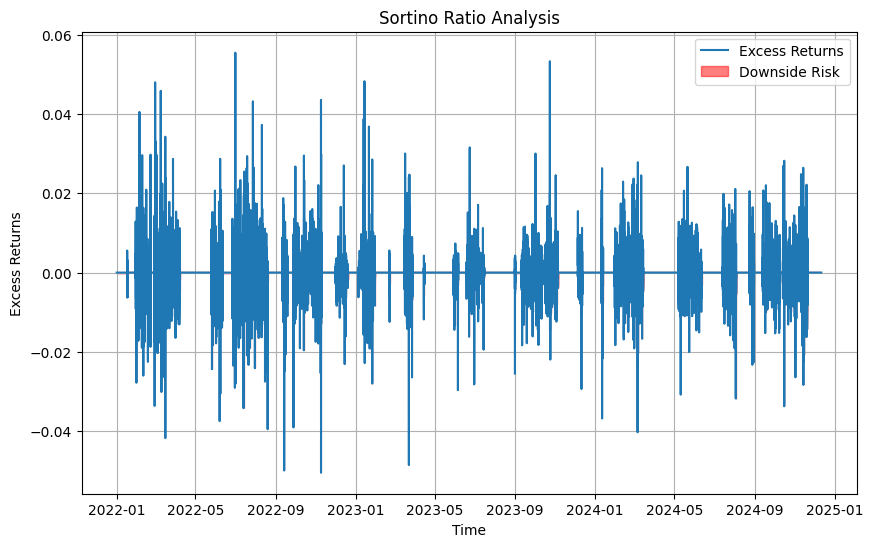

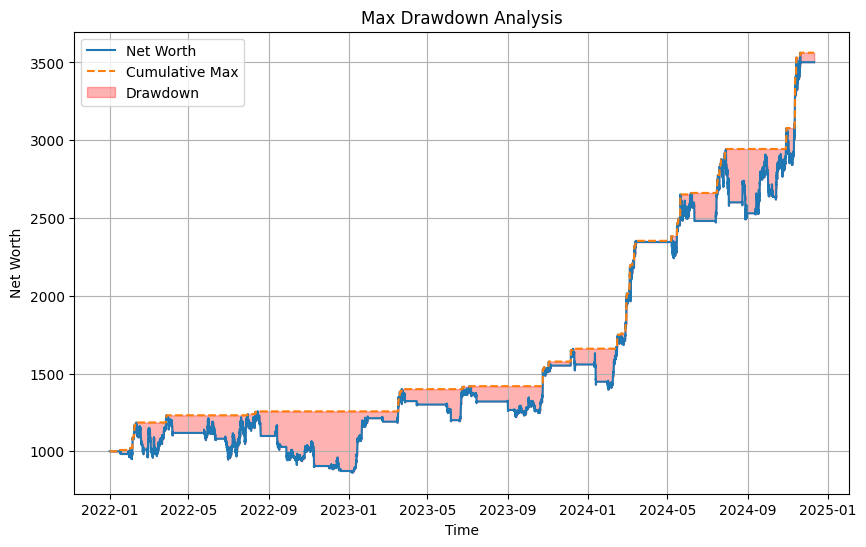

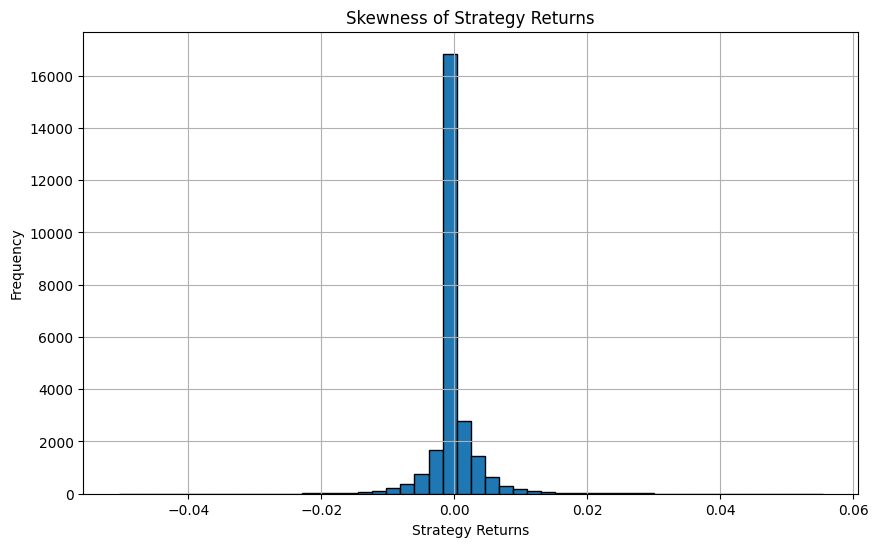

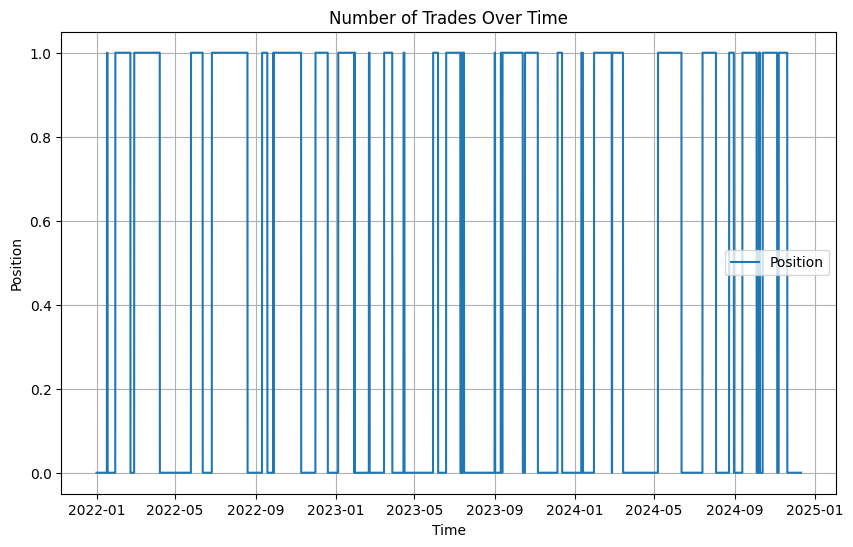

+-----------------------+-----------------------------------------------------+
|       Indicador       |                        Valor                        |
+-----------------------+-----------------------------------------------------+
|          PnL          |                  2501.273813915559                  |
|   Annualized Return   |                  0.53024952494038                   |
| Annualized Volatility |                 0.3472347359798402                  |
|     Profitability     | (0.2463768115942029, np.float64(7.653360486025783)) |
|     Sharpe Ratio      |                 1.2581922623407478                  |
|     Sortino Ratio     |                 1.8027557116847746                  |
|     Max Drawdown      |      (np.float64(-0.313907994316952), 3466.0)       |
|       Skewness        |                 0.28501216241588195                 |
|   Number of Trades    |                        34.0                         |
+-----------------------+---------------

In [6]:
apt1.backtest(visualize=True)

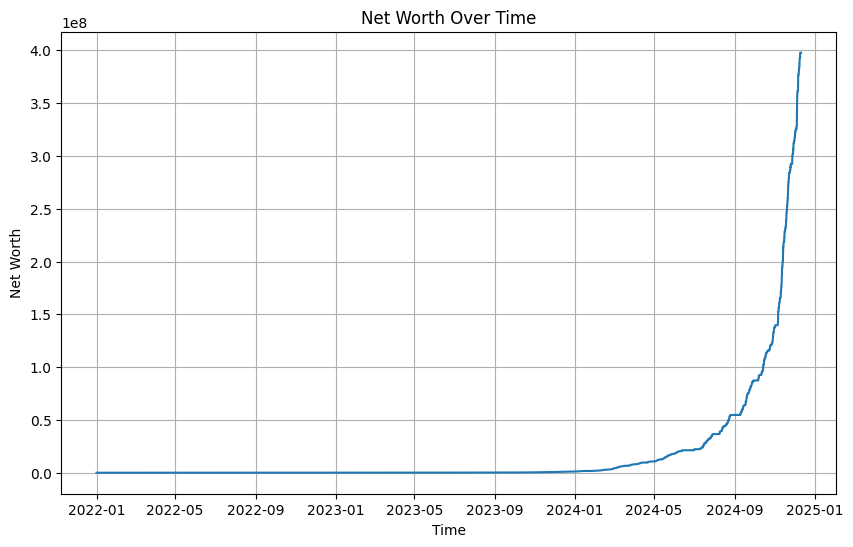

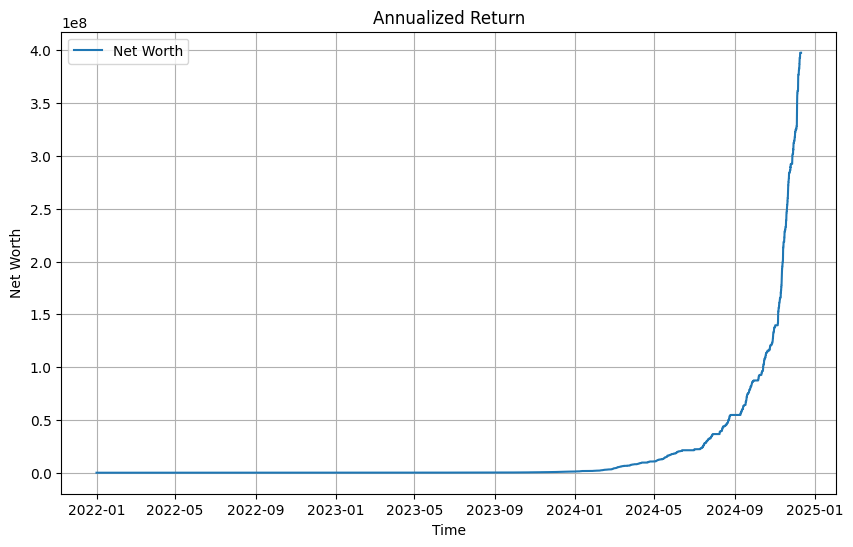

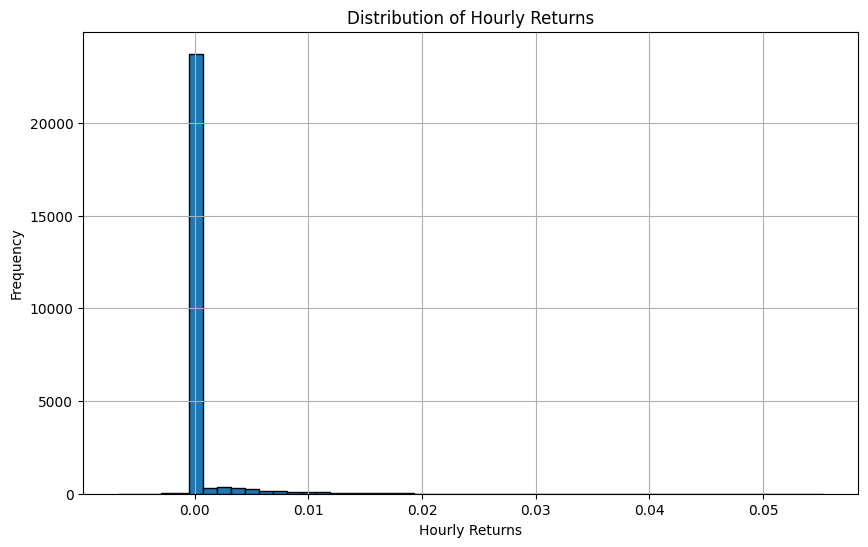

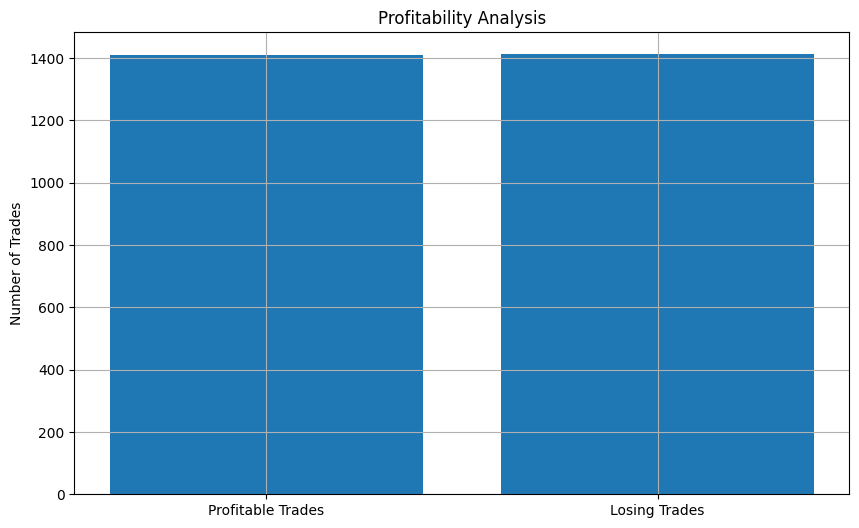

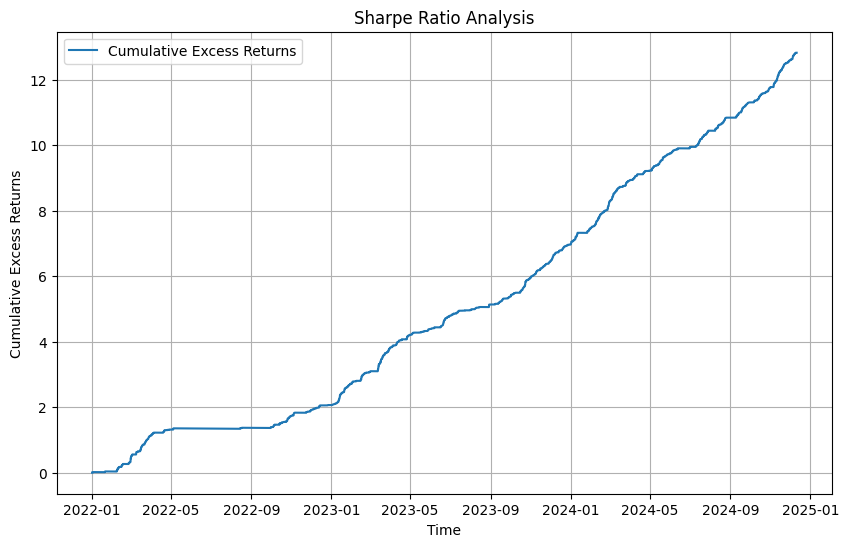

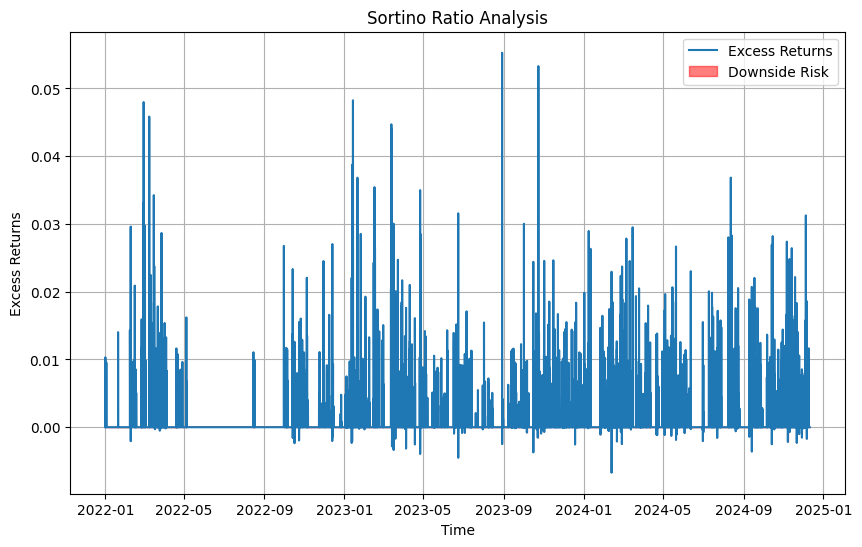

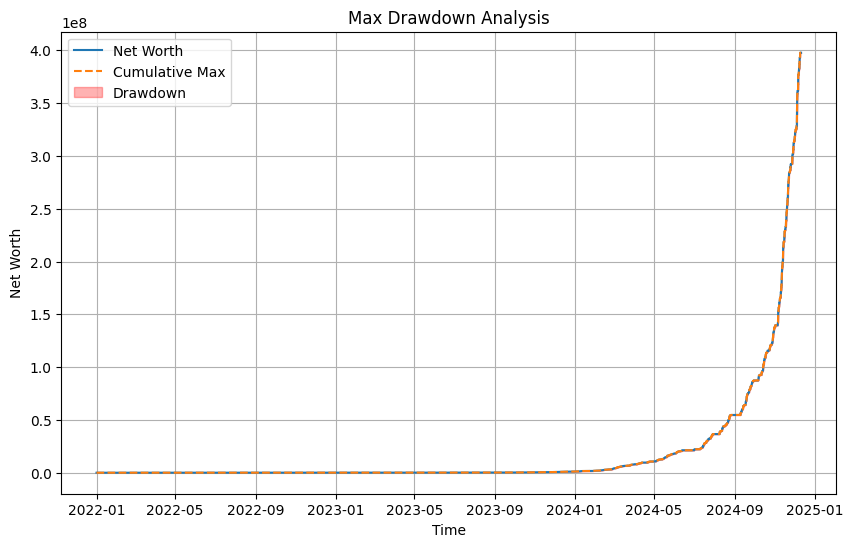

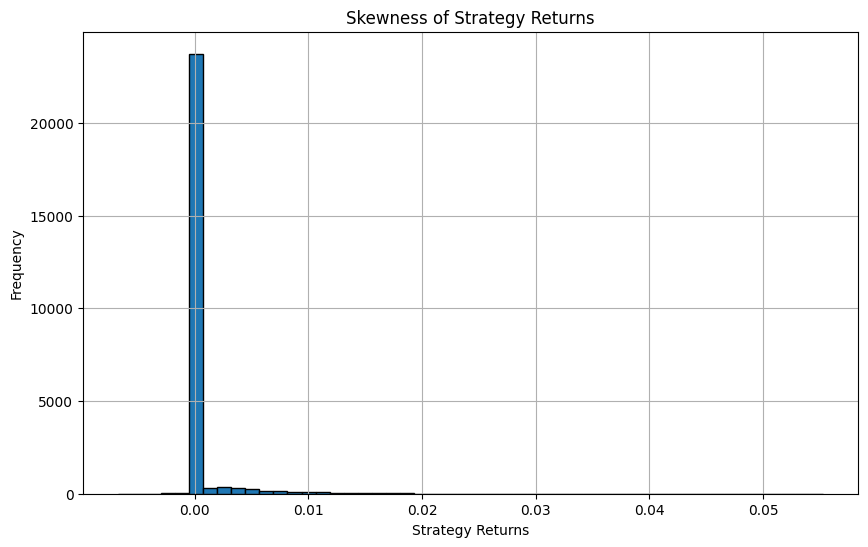

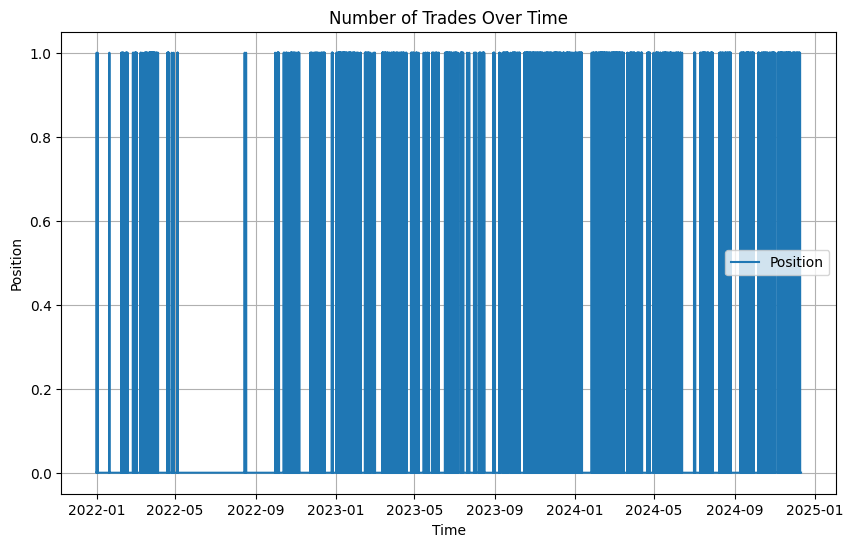

+-----------------------+-------------------------------------------------------+
|       Indicador       |                         Valor                         |
+-----------------------+-------------------------------------------------------+
|          PnL          |                  397731718.31944263                   |
|   Annualized Return   |                   78.6224499546115                    |
| Annualized Volatility |                  0.2266241979061643                   |
|     Profitability     | (0.49946827366182206, np.float64(28538.866418939124)) |
|     Sharpe Ratio      |                  19.215826489910906                   |
|     Sortino Ratio     |                  440.91338240147167                   |
|     Max Drawdown      |        (np.float64(-0.00672044841719789), 1.0)        |
|       Skewness        |                   8.017120546711183                   |
|   Number of Trades    |                        1410.0                         |
+---------------

In [5]:
apt.backtest(visualize=True)

In [3]:
BnH = BuyNHold(1000,'2021-01-01', 'now')

INFO:root:Successfully fetched data for endpoint: market/price_usd_close
INFO:root:Successfully fetched data for endpoint: indicators/ssr_oscillator
INFO:root:Successfully fetched data for endpoint: market/spot_cvd_sum
INFO:root:Successfully fetched data for endpoint: supply/profit_relative
INFO:root:Successfully fetched data for endpoint: mining/hash_rate_mean
INFO:root:Successfully merged data from all endpoints.
INFO:root:Fetched 1000 rows, total fetched: 1000
INFO:root:Fetched 1000 rows, total fetched: 2000
INFO:root:Fetched 1000 rows, total fetched: 3000
INFO:root:Fetched 1000 rows, total fetched: 4000
INFO:root:Fetched 1000 rows, total fetched: 5000
INFO:root:Fetched 1000 rows, total fetched: 6000
INFO:root:Fetched 1000 rows, total fetched: 7000
INFO:root:Fetched 1000 rows, total fetched: 8000
INFO:root:Fetched 1000 rows, total fetched: 9000
INFO:root:Fetched 1000 rows, total fetched: 10000
INFO:root:Fetched 1000 rows, total fetched: 11000
INFO:root:Fetched 1000 rows, total fetch

Wrapper Activated. Demo Mode == True


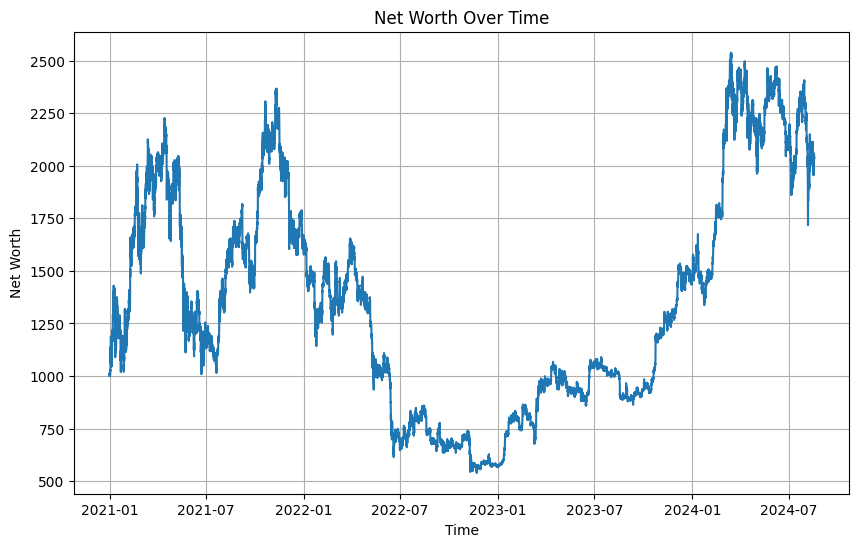

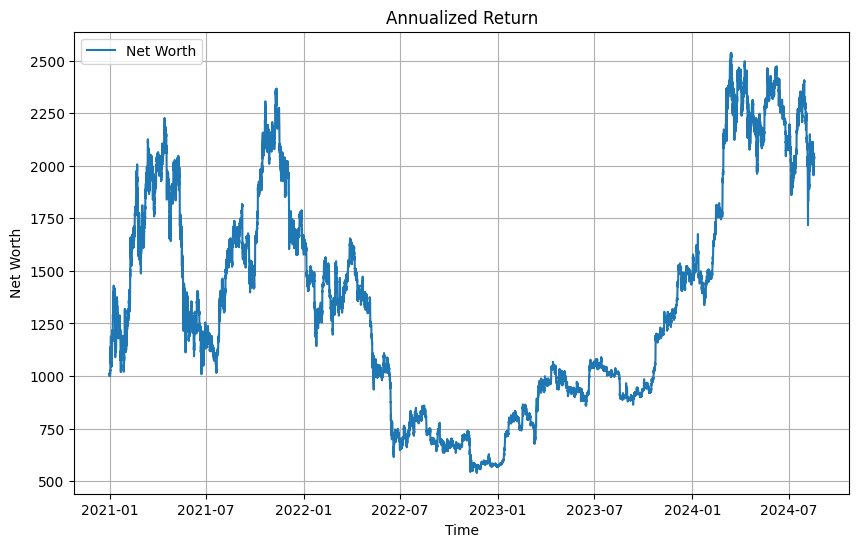

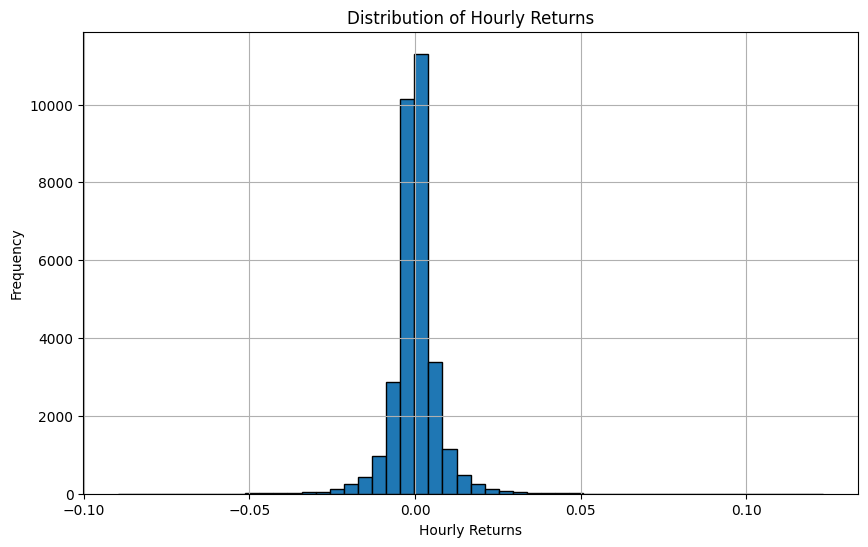

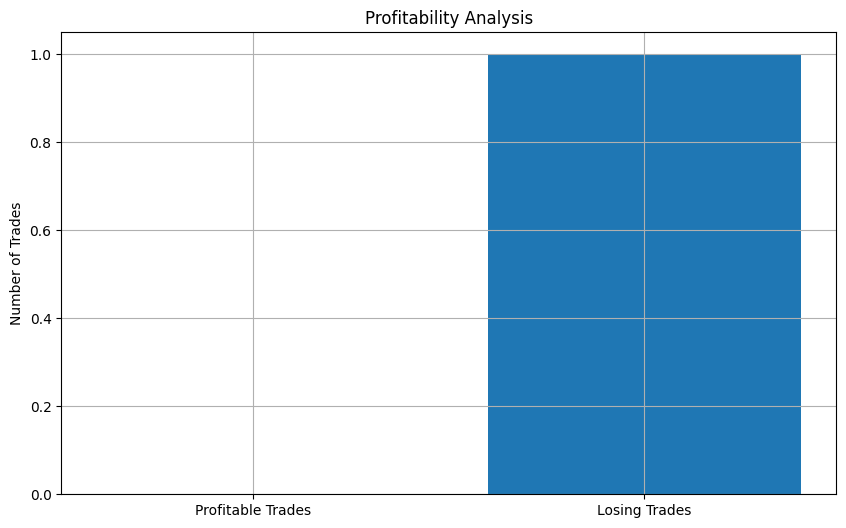

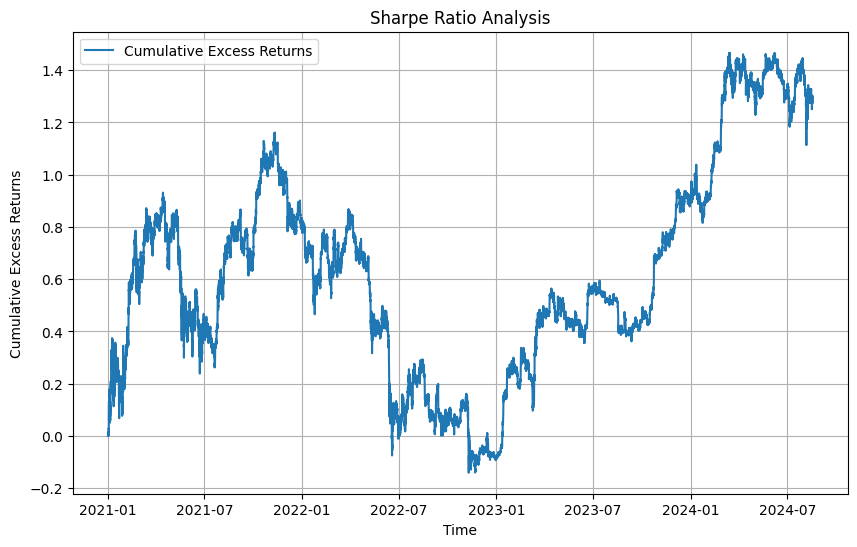

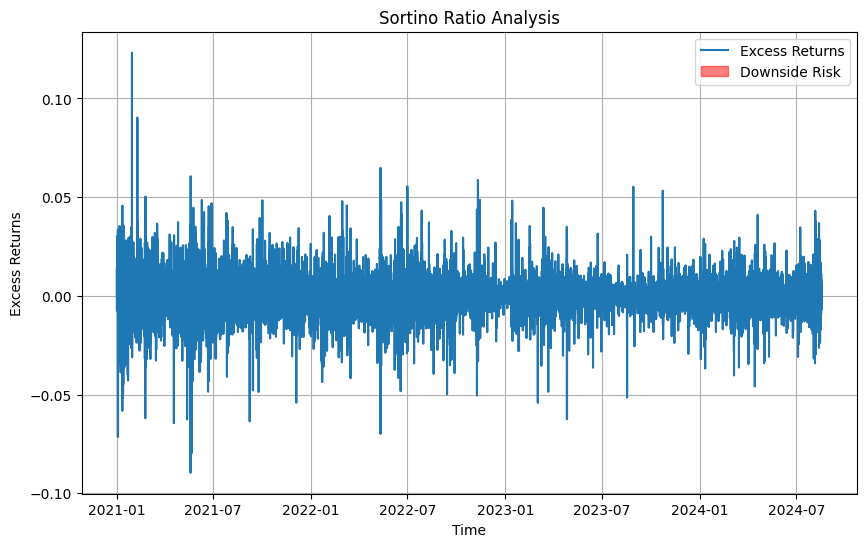

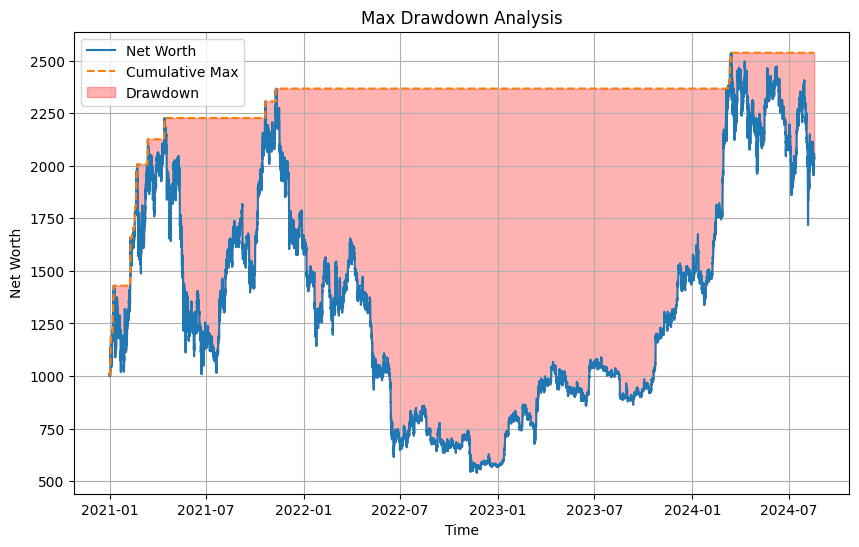

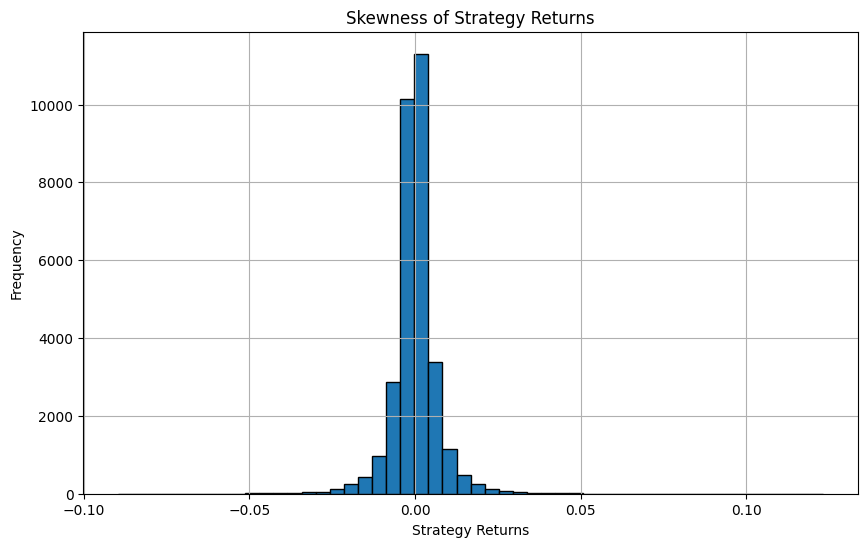

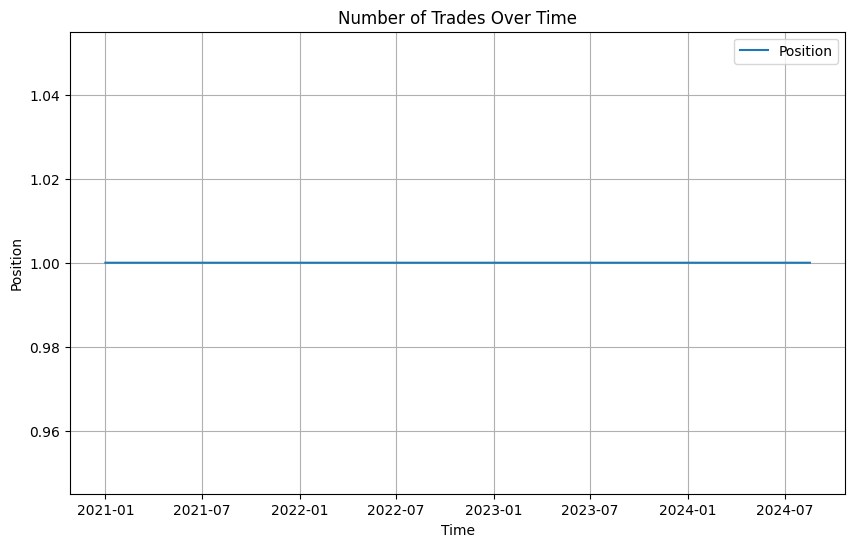

+-----------------------+-------------------------------------------+
|       Indicador       |                   Valor                   |
+-----------------------+-------------------------------------------+
|          PnL          |            1038.9292960576615             |
|   Annualized Return   |            0.2169999099895792             |
| Annualized Volatility |            0.6462641343184123             |
|     Profitability     |                 (0.0, 0)                  |
|     Sharpe Ratio      |            0.5516593448613711             |
|     Sortino Ratio     |             0.751498792636042             |
|     Max Drawdown      | (np.float64(-0.7719848663243939), 9028.0) |
|       Skewness        |           -0.014968963706906526           |
|   Number of Trades    |                    0.0                    |
+-----------------------+-------------------------------------------+


In [5]:
BnH.backtest(visualize=True)